# PyTorch Going Modular: Refactoring for Readability and Reusability

This notebook demonstrates how to refactor a PyTorch deep learning project into a modular structure by moving code into separate Python scripts. This approach improves code organization, reusability, and testability.

## Setting up the Project Structure

We'll begin by creating a directory that will house our modular Python scripts. This directory will serve as a Python package.

In [1]:
import torch
from going_modular import data_setup, transformations, predictions, model_builder, plotting, engine, utils

from going_modular.data_setup import DataManager
from going_modular.transformations import simple_transform, trivial_transform, auto_augment_transform

from going_modular.model_builder import TinyVGG
from going_modular.utils import save_model
from going_modular.path_file import train_dir, test_dir

from torchinfo import summary

## 1. Defining Project Paths (`path_file.py`)

Centralizing file paths makes it easier to manage data, models, and results. We'll use `pathlib` for a more robust way to handle paths.

In [1]:
%%writefile going_modular/path_file.py
from pathlib import Path

data_dir = Path('data')
images_dir = data_dir / 'pizza_steak_sushi'

train_dir = data_dir / "train"
test_dir = data_dir / "test"

models_dir = 'models'
model_dir_prefix = 'model_'
results_filename = 'results.csv'


Overwriting going_modular/path_file.py


## 2. Data Setup (`data_setup.py`)

Code for handling data loading, transformations, and creating DataLoaders is moved to a dedicated script.

In [10]:
%%writefile going_modular/transformations.py
"""
transformations.py

Module containing predefined sets of torchvision transformations 
for creating PyTorch datasets.
"""

from torchvision import transforms

simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

trivial_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
    ])

auto_augment_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.AutoAugment(),
    transforms.ToTensor()
    ])

Overwriting going_modular/transformations.py


In [8]:
%%writefile going_modular/data_setup.py
"""
data_setup.py

Module for setting up data loading for PyTorch models.

Provides a DataManager class that:
- Loads training and testing datasets from directories
- Applies image transformations
- Creates and returns DataLoaders for training and evaluation

Intended for modular deep learning workflows.
"""

import os
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from .path_file import train_dir, test_dir
from .transformations import simple_transform

class DataManager():
    """
    A class for managing PyTorch datasets and creating DataLoaders.

    It takes training and testing directories along with image transformations,
    and converts them into PyTorch Datasets and DataLoaders.

    This makes the data handling process easier and more modular.

    Args:
        train_dir (str): Path to the training images directory.
        test_dir (str): Path to the testing images directory.
        transform (transforms.Compose): Transformations to apply to the training images.
        test_transform (transforms.Compose, optional): Transformations for test images.
            If None, the same transformations as 'transform' will be applied to the test set.
    """
    
    
    def __init__(self, 
                 train_dir: str = train_dir,
                 test_dir: str = test_dir,
                 transform: transforms.Compose = simple_transform,
                 test_transform: transforms.Compose = None):

        self.train_dir = train_dir
        self.test_dir = test_dir
        self.transform = transform
        self.test_transform = transform if test_transform is None else test_transform
        self.batch_size = None
        self.num_workers = None

        self.train_dataset = ImageFolder(root=self.train_dir, transform=self.transform)
        self.test_dataset = ImageFolder(root=self.test_dir, transform=self.test_transform)
        self.classes = self.test_dataset.classes

    
    def create_dataloaders(self,
                           batch_size: int = 32,
                           num_workers: int = os.cpu_count() - 1,
                           shuffle_train: bool = True,
                           shuffle_test: bool = False):
        """
        Creates DataLoaders for the training and testing datasets.

        Args:
            batch_size (int): Number of samples per batch (default: 32).
            num_workers (int): Number of CPU cores used for data loading (default: available CPU cores - 1).
            shuffle_train (bool): Whether to shuffle the training dataset (default: True).
            shuffle_test (bool): Whether to shuffle the testing dataset (default: False).

        Returns:
            Tuple[DataLoader, DataLoader, List[str]]: 
                A tuple containing (train_loader, test_loader, class_names).
        """
        
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.shuffle_train = shuffle_train
        self.shuffle_test = shuffle_test
    
        train_loader = DataLoader(dataset=self.train_dataset,
                                  batch_size=self.batch_size,
                                  shuffle=self.shuffle_train,
                                  num_workers=self.num_workers)
    
        test_loader = DataLoader(dataset=self.test_dataset,
                                 batch_size=self.batch_size,
                                 shuffle=self.shuffle_test,
                                 num_workers=self.num_workers)
    
        return train_loader, test_loader, self.classes


Overwriting going_modular/data_setup.py


#### Check data_setup code

In [3]:
data = DataManager(train_dir=train_dir, test_dir=test_dir, transform=simple_transform)
train_dataloader, test_dataloader, classes = data.create_dataloaders()

train_dataloader, test_dataloader, classes


(<torch.utils.data.dataloader.DataLoader at 0x247611ccce0>,
 ['pizza', 'steak', 'sushi'])

### 3. Model builder

Class with PyTorch model architecture. For our case we replicated TinyVGG architecture from [CNN Explainer](https://poloclub.github.io/cnn-explainer/)

In [8]:
%%writefile going_modular/model_builder.py
"""
model_builder.py

Module containing a TinyVGG model architecture based on 
CNN Explainer project: https://poloclub.github.io/cnn-explainer/

Provides:
- TinyVGG: A small CNN for image classification tasks.
"""

from torch import nn


class TinyVGG(nn.Module):
    """
    TinyVGG architecture recreated from CNN Explainer.
    
    Args:
        in_channels (int): Number of input channels (e.g., 3 for RGB images).
        hidden_units (int): Number of units in the convolutional layers.
        out_features (int): Number of output classes.
    """

    def __init__(self, in_channels: int, hidden_units: int, out_features: int):
        super().__init__()

        self.layer_stack_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer_stack_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=out_features))

    def forward(self, x):
        return self.classifier(self.layer_stack_2(self.layer_stack_1(x)))



Overwriting going_modular/model_builder.py


### 3.1 Pass data throught the model

In [4]:
dummy_x = torch.randn((1, 3, 64, 64))
model = TinyVGG(3, 10, 3)

model(dummy_x)


tensor([[ 0.0292, -0.0106,  0.0464]], grad_fn=<AddmmBackward0>)

### 3.2 Check model layers

In [5]:
summary(model=model, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 4. Modular Utility Functions (`utils.py`)

Helper functions, such as saving and loading models, are placed in a utilities script.

In [6]:
%%writefile going_modular/utils.py
"""
utils.py

Utility functions for saving PyTorch models.
"""

import torch
import os
from pathlib import Path
import pandas as pd
from typing import Dict, List
from .path_file import models_dir, model_dir_prefix

def create_model_directory(MODELS_PATH: str = models_dir, PREFIX: str = model_dir_prefix):
    """
    Creates a new directory for a model with a unique name.

    Checks if the main models directory exists and creates it if not.
    Finds existing model directories with the given prefix and a numeric suffix.
    Generates a new directory name by incrementing the highest existing number.

    Args:
        MODELS_PATH: Path to the main directory for models. Defaults to 'models'.
        PREFIX: Prefix for model directory names. Defaults to 'model_'.

    Returns:
        The path to the newly created model directory.
    """

    if not os.path.exists(MODELS_PATH):
        os.mkdir(MODELS_PATH)
        print(f'Directory "{MODELS_PATH}" has been created')
    
    model_dir_list = [x for x in os.listdir(MODELS_PATH) if (x[:len(PREFIX)] == PREFIX)
                      and (x[len(PREFIX):].isdigit())]
    
    if model_dir_list:
        dir_index_list = [int(x[len(PREFIX):]) for x in model_dir_list]
        dir_index_new = str(max(dir_index_list) + 1)
    else: 
        dir_index_new = '0'
     
    dir_name = PREFIX + dir_index_new
    model_dir_path = os.path.join(MODELS_PATH, dir_name)
    
    try:
        os.mkdir(model_dir_path)
        print(f'Directory "{model_dir_path}" has been created')
        
    except FileExistsError:
        print(f'Directory "{model_dir_path}" arleady exist')

    return model_dir_path


def save_model(model: torch.nn.Module,
               model_dir_path: str,
               filename: str = 'model.pt'):
    """
    Saves a PyTorch model's state_dict to the 'models/' directory.

    Args:
        model (torch.nn.Module): The PyTorch model to save.
        model_dir_path (str): Directory to save thee model weights.
        filename (str): The name of the file to save the model weights to.
                        Must include '.pt' or '.pth' extension.

    Example:
        save_model(model, "models_dir", "model_filename.pt")
    """
    torch.save(model.state_dict(), os.path.join(model_dir_path, filename))
    print(f'Saved model to "{os.path.join(model_dir_path, filename)}"')


def save_results_to_csv(model_results: Dict[str, List[float]],
                        model_dir_path: str,
                        filename: str = 'results.csv'):
    """
    Saves model results to a CSV file in a newly created model directory.

    Args:
        model_results: Dictionary where keys are metric names and values are lists of results.
        filename: Name of the CSV file to save to. Defaults to 'results.csv'.

    """
    try:
        model_results_df = pd.DataFrame(model_results, columns=model_results.keys())
        model_results_df = model_results_df.astype('float')
        file_path = os.path.join(model_dir_path, filename)
        model_results_df.to_csv(file_path)
        print(f'Saved model results to: "{file_path}"')
    except Exception as e:
        print(f"An error occurred while saving results: {e}")

Overwriting going_modular/utils.py


## 5. Modular Training and Testing Engine (`engine.py`)

The core training and testing loops are abstracted into functions in a dedicated engine script.

In [6]:
%%writefile going_modular/engine.py
"""
engine.py

Module containing functions for training and testing PyTorch models.

Provides:
- train_step: One step of training through the dataloader.
- test_step: One step of evaluation through the dataloader.
- print_metrics: Nicely formatted printing of training/test metrics.
- train: Full training loop across multiple epochs.
"""

import torch
from torch import nn
from typing import Dict, List
from .utils import save_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn,
               optimizer: torch.optim,
               device=device):
    """
    Runs a single training step over a dataloader.

    Args:
        model: A PyTorch model.
        dataloader: Dataloader containing the training data.
        loss_fn: Loss function to compute the loss.
        optimizer: Optimizer to update model weights.
        device: Device to run the computations on ('cpu' or 'cuda').

    Returns:
        Tuple of (train_loss, train_accuracy).
    """

    # set train mode
    model.train()

    # init metrics
    train_loss = 0
    train_accuracy = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # pred
        y_logits = model(X)
        y_pred = y_logits.argmax(dim=1)

        # metrics
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        train_accuracy += ((y_pred == y).sum()/len(y)).item()

        # gradient operations
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)

    return train_loss, train_accuracy


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn,
              device=device):
    """
    Runs a single testing step over a dataloader.

    Args:
        model: A PyTorch model.
        dataloader: Dataloader containing the test data.
        loss_fn: Loss function to compute the loss.
        device: Device to run the computations on ('cpu' or 'cuda').

    Returns:
        Tuple of (test_loss, test_accuracy).
    """

    # set eval mode
    model.eval()

    # init metrics
    test_loss = 0
    test_accuracy = 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # pred
            y_logits = model(X)
            y_pred = y_logits.argmax(dim=1)

            # metrics
            test_loss += loss_fn(y_logits, y).item()
            test_accuracy += ((y_pred == y).sum()/len(y)).item()

        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)

    return test_loss, test_accuracy


def print_metrics(epoch: int, results: Dict[str, float]):
    """
    Nicely formats and prints training and testing metrics per epoch.

    Args:
        epoch: Current epoch number.
        results: Dictionary containing lists of train/test losses and accuracies.
    """

    train_output = ' | '.join("{}: {}".format(k.split('_', 1)[1].capitalize(), round(v[-1], 3 if k=='train_loss' else 2)) for k, v in results.items() if k.split('_', 1)[0] == 'train')
    test_output = ' | '.join("{}: {}".format(k.split('_', 1)[1].capitalize(), round(v[-1], 3 if k=='test_loss' else 2)) for k, v in results.items() if k.split('_', 1)[0] == 'test')

    print(50*'-')
    print(f'Epoch: {epoch}')
    print('Train -> ', train_output)
    print('Test  -> ', test_output)
    print()


def train(model: torch.nn.Module, epochs: int, train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn, optimizer: 
          torch.optim, model_dir_path: str, device=device) -> Dict[str, List]:
    """
    Full training loop for a PyTorch model.

    Tracks and saves the best model based on test loss, and saves the last model.

    Args:
        model: A PyTorch model to train.
        epochs: Number of epochs to train for.
        train_dataloader: Dataloader for the training data.
        test_dataloader: Dataloader for the testing data.
        loss_fn: Loss function.
        optimizer: Optimizer for updating model weights.
        model_dir_path: Directory for saving model results
        device: Device to run the computations on ('cpu' or 'cuda').

    Returns:
        Dictionary containing training and testing metrics.
    """
    
    results = {'train_loss': [],
               'train_accuracy': [],
               'test_loss': [],
               'test_accuracy': []}
    
    best_model_loss = None
    
    for epoch in range(epochs):
        train_loss, train_accuracy = train_step(model,
                                                train_dataloader,
                                                loss_fn,
                                                optimizer,
                                                device)
        
        test_loss, test_accuracy = test_step(model,
                                             test_dataloader,
                                             loss_fn,
                                             device)
        
        results['train_loss'].append(train_loss)
        results['train_accuracy'].append(train_accuracy)
        results['test_loss'].append(test_loss)
        results['test_accuracy'].append(test_accuracy)
        
        print_metrics(epoch, results)

        if epoch == 0 or test_loss < best_model_loss:
            best_model_loss = test_loss
            save_model(model=model, model_dir_path=model_dir_path, filename='best.pt')

    save_model(model=model, model_dir_path=model_dir_path, filename = 'last.pt')
                
    return results


Overwriting going_modular/engine.py


### 5.1 Test `engine.py` script

In [7]:
model_dir_path = utils.create_model_directory()

data = data_setup.DataManager(train_dir, test_dir, simple_transform)
train_dataset, test_dataset = data.train_dataset, data.test_dataset
train_loader, test_loader, classes = data.create_dataloaders()


model = model_builder.TinyVGG(3, 10, len(classes))
model.load_state_dict(torch.load('models/best.pt', weights_only=True))

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

EPOCHS = 2


model_0_results = engine.train(model=model,
                        epochs=EPOCHS,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        model_dir_path=model_dir_path)


Directory "models\model_8" has been created
--------------------------------------------------
Epoch: 0
Train ->  Loss: 1.103 | Accuracy: 0.35
Test  ->  Loss: 1.663 | Accuracy: 0.42

Saved model to "models\model_8\best.pt"
--------------------------------------------------
Epoch: 1
Train ->  Loss: 1.058 | Accuracy: 0.53
Test  ->  Loss: 1.691 | Accuracy: 0.34

Saved model to "models\model_8\last.pt"


## 6. Creating the Main Training Script (`train.py`)

This script acts as the entry point, importing the modular components and orchestrating the entire training process, including handling command-line arguments.

In [21]:
%%writefile going_modular/train.py
"""
train.py

Main script to train a TinyVGG model on a custom dataset using PyTorch.
"""

import torch
from torchvision import transforms
from time import time
from . import data_setup, model_builder, engine, transformations, utils, path_file
import argparse

def main():

    # setup parser
    parser = argparse.ArgumentParser(description="Train a TinyVGG model on custom dataset.")
    parser.add_argument('-e', '--epochs', type=int, default=10, help='Number of epochs to train.')
    parser.add_argument('-b', '--batch_size', type=int, default=32, help='Batch size for training.')
    parser.add_argument('-lr', '--learning_rate', type=float, default=0.001, help='Learning rate for optimizer.')
    parser.add_argument('-hu', '--hidden_units', type=int, default=10, help='Number of hidden units in TinyVGG.')
    parser.add_argument('-n', '--num_workers', type=int, default=1, help='Number of CPU cores for data loading.')
    parser.add_argument('-t', '--transform', type=str, default='simple_transform', help='Type of train data transform',
                       choices=['simple_transform', 'trivial_transform', 'auto_augment_transform'])
    parser.add_argument('-tt', '--test_transform', type=str, default='simple_transform', help='Type of test data transform',
                       choices=['simple_transform', 'trivial_transform', 'auto_augment_transform'])
    args = parser.parse_args()

    # set train and test directiries
    train_dir = path_file.train_dir
    test_dir = path_file.test_dir
    
    # device agnostic code
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # define transformation
    try:
        transform = getattr(transformations, args.transform)
        test_transform = getattr(transformations, args.test_transform)
    except AttributeError:
        raise ValueError('Invalid transformtion selected')

    # create model directories
    model_dir_path = utils.create_model_directory()

    # create dataloaders
    data = data_setup.DataManager(train_dir=train_dir, test_dir=test_dir, transform=transform)
    
    train_dataloader, test_dataloader, classes = data.create_dataloaders(
        batch_size=args.batch_size,
        num_workers=args.num_workers
    )
    
    # init the classification model
    model = model_builder.TinyVGG(in_channels=3,
                                  hidden_units=args.hidden_units,
                                  out_features=len(classes)).to(device)
    
    # set loss function and optimizer
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(),
                                 lr=args.learning_rate)
    
    # training
    time_start = time()
    model_results = engine.train(model=model,
                                 epochs=args.epochs,
                                 train_dataloader=train_dataloader,
                                 test_dataloader=test_dataloader,
                                 loss_fn=loss_fn,
                                 optimizer=optimizer,
                                 model_dir_path=model_dir_path,
                                 device=device)

    utils.save_results_to_csv(model_results=model_results, model_dir_path=model_dir_path)
    print(f'Training completed in {(time() - time_start):.0f} seconds')


if __name__ == '__main__':
    main()


Overwriting going_modular/train.py


### 6.1 Running the Modular Script from the Command Line

We can now run the entire training pipeline directly from the terminal using `python -m` to correctly execute the module within the package context.

**Note:** Using `python -m going_modular.train` is the recommended way to run this script to ensure relative imports within the `going_modular` package work correctly. Running `python going_modular/train.py` directly can lead to import errors.

In [22]:
!python -m going_modular.train --epochs 1 --batch_size 32 --learning_rate 0.001 -t simple_transform --hidden_units 10 --num_workers 1

Directory "models\model_9" has been created
--------------------------------------------------
Epoch: 0
Train ->  Loss: 1.107 | Accuracy: 0.28
Test  ->  Loss: 1.643 | Accuracy: 0.36

Saved model to "models\model_9\best.pt"
Saved model to "models\model_9\last.pt"
Saved model results to: "models\model_9\results.csv"
Training completed in 15 seconds


## 7. Making Predictions with the Trained Model

Loading the saved model using our modular utility function and using it to make predictions.

In [8]:
%%writefile going_modular/predictions.py
"""
predictions.py

Module for making predictions with a trained PyTorch model on a given dataset.
"""

import torch
import random
import matplotlib.pyplot as plt
import numpy as np
from typing import List

def predict(model: torch.nn.Module,
            dataset: torch.utils.data.Dataset, 
            device = 'cpu') -> List[int]:
    """
    Makes predictions on a dataset using a trained model.

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        dataset (torch.utils.data.Dataset): Dataset to make predictions on.
        device (torch.device, optional): Device to perform computations on.

    Returns:
        List[int]: List of predicted class indices.
    """

    model.eval()
    list_of_predictions = []
    
    with torch.inference_mode():
        for img, label in dataset:
            img = img.to(device)
            y_pred = model(img.unsqueeze(dim=0)).argmax(dim=1)
            list_of_predictions.append(y_pred.item())
    return list_of_predictions


Overwriting going_modular/predictions.py


### 7.1 Test `predictions.py` script

In [2]:
data = data_setup.DataManager(train_dir, test_dir, transformations.simple_transform)
train_dataset, test_dataset = data.train_dataset, data.test_dataset
classes = data.classes

model = model_builder.TinyVGG(3, 10, len(classes))
model.load_state_dict(torch.load('models/model_0/best.pt', weights_only=True))

y_pred = predictions.predict(model, test_dataset)
y_pred[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## 8. Plotting Results

Visualize visualize visualize

In [6]:
%%writefile going_modular/plotting.py
import torch
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import os
from pathlib import Path
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import List
from .path_file import models_dir, results_filename
from .predictions import predict
import seaborn as sns

def plot_transform(path: str,
                   transform: transforms.Compose or List[transforms.Compose],
                   n: int = 10,
                   fig_width: int = 10,
                   show_img_shapes: bool = True):
    """
    Plots original and transformed versions of random images from a dataset.

    Args:
        path (str): Path to the dataset directory.
        transform (Compose or list of Compose): Transformations to apply.
        n (int): Number of images to display (max 10).
        fig_width (int): Width of the plot.
        show_img_shapes (bool): Whether to display image shapes.

    Raises:
        TypeError: If `transform` has an invalid type.
    """

    if type(transform) is transforms.Compose:
        transform = [transform]

    elif type(transform) is list:
        pass

    else:
         raise TypeError(
            f'Expected transform to be torchvision.transforms.Compose or List[...] but got {type(transform)}'
         )

    
    if n > 10:
        n = 10
        print("Can\'t display more than 10 images. Showing 10.")
        
    list_of_images = list(Path(path).glob('*/*.jpg'))
    random_images = random.choices(list_of_images, k=n)

    nrows = n
    ncols = len(transform)+1

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_figwidth(fig_width)
    fig.set_figheight(fig_width * nrows / ncols)
    
    for i, img_path in enumerate(random_images):
        
        img = Image.open(img_path)
        img_arr = np.asarray(img)
        label = img_path.parent.stem
        
        ax[i, 0].imshow(img_arr)
        ax[i, 0].set(xticks=[], yticks=[])
        if show_img_shapes:
            ax[i, 0].set_xlabel(list(img_arr.shape), fontsize=10)
        ax[i, 0].set_ylabel(label, fontsize=16)
        ax[0, 0].set_title('Original', fontsize=16)

        
        for j, t in enumerate(transform):
            img_trans = t(img)
            ax[i, j+1].imshow(img_trans.permute(1, 2, 0))
            ax[i, j+1].set(xticks=[], yticks=[])
            if show_img_shapes:
                ax[i, j+1].set_xlabel(list(img_trans.shape), fontsize=10)
            ax[0, j+1].set_title(f'Transform {j+1}', fontsize=16)

    plt.tight_layout()
    plt.show()


def plot_predict_images(model: torch.nn.Module,
                        dataset: torch.utils.data.Dataset,
                        n_samples: int = 10,
                        fig_width: int = 10):
    """
    Plots random images from a dataset with true and predicted labels.

    Args:
        model (nn.Module): Trained (or untrained) PyTorch model.
        dataset (Dataset): Dataset containing images and labels.
        n_samples (int): Number of images to plot (max 60).
        fig_width (int): Width of the entire figure.
    """
    
    if n_samples > 60:
        print("Can't plot more imaages than 60.\nPlotting 60 images.\n")
        n_samples = 60

    cols = 5 if n_samples > 19 else 4 if n_samples > 10 else 3 if n_samples > 4 else 2 if n_samples > 1 else 1
    rows = int(np.ceil(n_samples/cols))
    
    random_idx = random.sample(range(len(dataset)), rows*cols)

    fig, ax = plt.subplots(nrows=rows, ncols=cols)
    fig.set_figwidth(fig_width)
    fig.set_figheight(fig_width * rows / cols)
    ax = np.array(ax).flatten()

    for i, idx in enumerate(random_idx):
        img, label = dataset[idx]
        
        model.eval()
        with torch.inference_mode():
            y_pred_probs = torch.softmax(model(img.unsqueeze(0)), dim=1)
            y_pred = y_pred_probs.argmax(dim=1)
            
        true_class = dataset.classes[label]
        pred_class = dataset.classes[y_pred]
        
        ax[i].imshow(img.permute(1, 2, 0))
        ax[i].text(0.5, 1.1, true_class + ' |',
                   transform=ax[i].transAxes,
                   ha='right', va='top',
                   fontsize=12, color='black')
        ax[i].text(0.5, 1.1, pred_class,
                   transform=ax[i].transAxes,
                   ha='left', va='top',
                   fontsize=12,
                   color='green' if pred_class == true_class else 'red')
        ax[i].set(xticks=[], yticks=[])


    print(f'Images plot: {cols*rows}\n')
    plt.tight_layout()
    plt.show()


def plot_all_models_result(directory: str = models_dir, result_filename: str = results_filename):
    '''
    Finds result files in model subdirectories and plots specified metrics.

    Searches for `result_filename` in subdirectories within `directory`, reads
    the data (assuming CSV format), and plots each column as a separate series.

    Args:
        directory (str): The main directory to search for model results.
                         Defaults to `models_dir`.
        result_filename (str): The name of the result file to find.
                               Defaults to `results_filename`.
    '''
    
    list_of_model_result = list(Path(directory).glob(f'*/*{result_filename}'))
        
    if list_of_model_result:
        fig = plt.figure(figsize=(12, 15))
    else:
        print(f'Not found "{result_filename}" in "{directory}" directory')

    for result in list_of_model_result:
        df_result = pd.read_csv(result, index_col=0)

        for i, metric in enumerate(df_result.columns):
            plt.subplot(len(df_result.columns), 2, i+1)
            plt.plot(df_result.index, df_result[metric], label=result.parent.stem)
            plt.title(metric)
            plt.legend()


def plot_confussion_matrix(model: torch.nn.Module,
                           dataset: torch.utils.data.Dataset,
                           normalize='pred'):
    '''
    Calculates and plots a confusion matrix for a given model and dataset.

    Makes predictions using the model, computes the confusion matrix against
    true labels, and visualizes it using seaborn.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        dataset (torch.utils.data.Dataset): The dataset for evaluation,
                                             requires `.targets` and `.classes`.
        normalize (str, optional): Normalization method ('true', 'pred', 'all', or None).
                                   Defaults to None.
    '''
    
    y = dataset.targets
    y_pred = predict(model, dataset)

    if not normalize:
        normalize = None
        
    cm = confusion_matrix(y, y_pred, normalize=normalize)

    fmt = '.1%'  if normalize else '.0f'
    title = 'Confusion matrix - normalized' if normalize else 'Confusion matrix'
    
    sns.heatmap(cm, annot=True, cmap='Blues', fmt=fmt, xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(title)
    plt.xlabel('Prediction')
    plt.ylabel('True')


Overwriting going_modular/plotting.py


### 8.1 Check predict images function

Images plot: 2



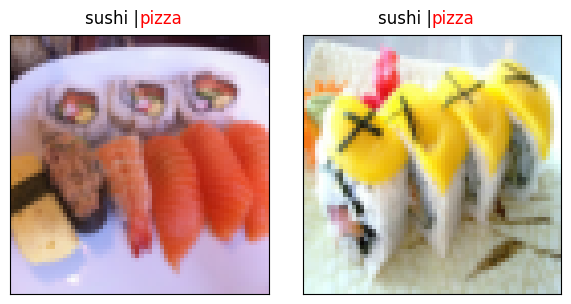

In [26]:
plotting.plot_predict_images(model=model, dataset=test_dataset, n_samples=2, fig_width=6)

### 8.1 Checkplot transform function

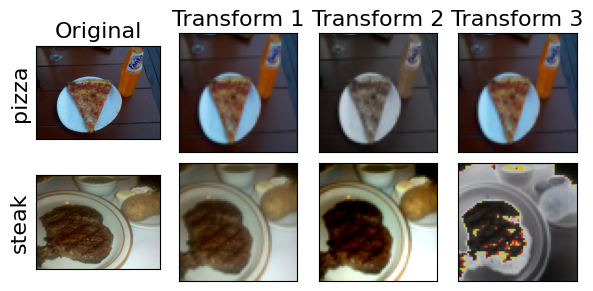

In [27]:
plotting.plot_transform(path=train_dir,
               transform = [simple_transform, trivial_transform, auto_augment_transformation],
               n=2, show_img_shapes=False, fig_width=6)

### 8.1 Check all models result function

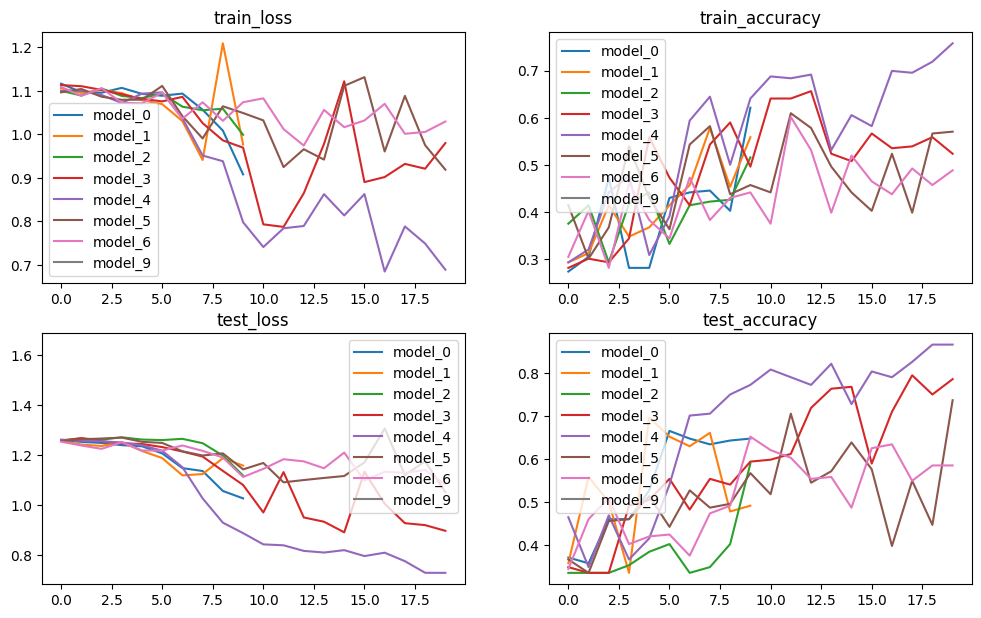

In [28]:
plotting.plot_all_models_result()

### 8.1 Check confussion matrix plotting function

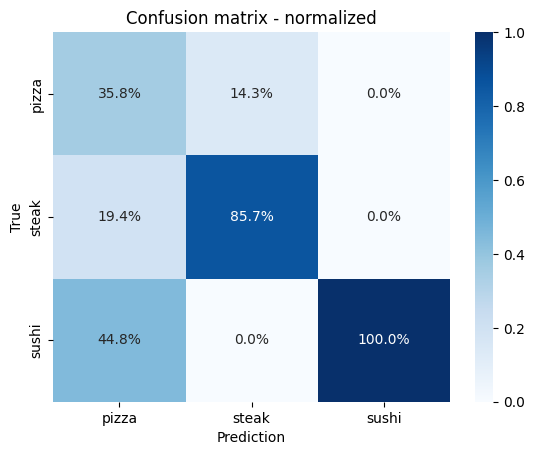

In [3]:
plotting.plot_confussion_matrix(model=model, dataset=test_dataset)

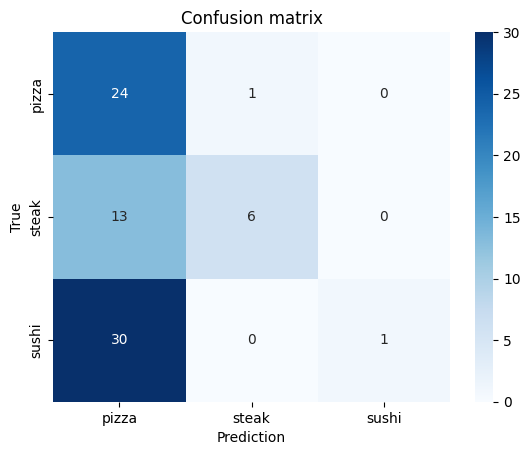

In [5]:
plotting.plot_confussion_matrix(model=model, dataset=test_dataset, normalize=False)